# Perkenalan

Nama: Deoputra Wardiman<br>
Batch: 001

Tujuan dari projek ini adalah menebak genre anime dari input poster dan/atau sinopsis anime tersebut. Yang menjadi tantangan dalam projek ini adalah poster anime mempunyai variasi yang cukup banyak dan trend dalam pembuatan poster juga berubah seiring dengan perkembangan jaman. Untuk sinopsis juga mempunya tantangan yaitu sumber penulisan sinopsis itu juga bermacam-macam. Ada yang di copy-paste dari Wikipedia, ada yang ditulis dari sinopsis resmi anime tersebut ada juga yang ditulis oleh volunteer website.

 Ini

Data adalah 11800 judul anime yang didapat dari hasil webscraping website database anime yang cukup terkenal yaitu https://myanimelist.net/ menggunakan Scrapy. My Anime List itu lebih tepat dimengerti sebagai suatu komunitas dibandingkan sebagai ensiklopedi.Ini menyebabkan data menjadi bermacam-macam. Kode Python untuk webscraping dapat diambil [Github saya](https://github.com/deowardiman/MAL_Classifier/tree/main/malscrapy). 

Data csv dan gambar juga dapat diambil di [kaggle saya](https://www.kaggle.com/deowardiman/myanimelist-dataset)

# Import Pustaka

In [1]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import pandas as pd
import numpy as np
from tqdm import tqdm


import tensorflow as tf
from tensorflow import keras

np.random.seed(42)

# Load Data

In [2]:
df = pd.read_csv('maltodata_2021-09-03T05-59-42.csv')

## Penjelasan untuk setiap kolom

description: sinopsis dari anime<br>
image_urls: url menuju gambar<br>
images: path menuju gambar yang sudah tersimpan di folder lokal<br>
misc: genre anime semicolon delimited<br>
ranking: rank anime berdasarkan rating secara sederhana digunakan sebagai ID<br>
rating<br>
season: periode anime itu keluar (hanya berlaku untuk series)<br>
title: judul anime<br>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11800 entries, 0 to 11799
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  11800 non-null  object 
 1   image_urls   11795 non-null  object 
 2   images       11786 non-null  object 
 3   misc         11777 non-null  object 
 4   ranking      11800 non-null  object 
 5   rating       11786 non-null  float64
 6   season       3961 non-null   object 
 7   title        11800 non-null  object 
dtypes: float64(1), object(7)
memory usage: 737.6+ KB


# Data Cleaning

Drop kolom Season dan Rating karena untuk sekarang tidak dibutuhkan

In [4]:
df = df.drop(columns=['season','rating']).dropna()

In [5]:
df = df[df['description'] != 'No synopsis information has been added to this title. Help improve our database by adding a synopsis ,.']

In [6]:
df

,description,image_urls,images,misc,ranking,title
0,Yabuki Joe is left downhearted and hopeless af...,https://cdn.myanimelist.net/images/anime/3/450...,[{'url': 'https://cdn.myanimelist.net/images/a...,Action;Drama;Shounen;Slice of Life;Sports,#50,Ashita no Joe 2
1,"In the 24th century on the planet Aqua, three ...",https://cdn.myanimelist.net/images/anime/6/776...,[{'url': 'https://cdn.myanimelist.net/images/a...,Sci-Fi;Slice of Life;Fantasy;Shounen,#100,Aria the Origination
2,Having reached professional status in middle s...,https://cdn.myanimelist.net/images/anime/6/828...,[{'url': 'https://cdn.myanimelist.net/images/a...,Drama;Game;Seinen;Slice of Life,#150,3-gatsu no Lion
3,Two special episodes bundled in the fourth and...,https://cdn.myanimelist.net/images/anime/3/848...,[{'url': 'https://cdn.myanimelist.net/images/a...,Slice of Life;Demons;Supernatural;Drama;Shoujo,#200,Natsume Yuujinchou Go Specials
4,The All-Star Tournament is a three-day event t...,https://cdn.myanimelist.net/images/anime/1825/...,[{'url': 'https://cdn.myanimelist.net/images/a...,Action;Game,#250,Quanzhi Gaoshou Specials
...,...,...,...,...,...,...
11795,Usa has a weather show with a guest slug who i...,https://cdn.myanimelist.net/images/anime/1417/...,[{'url': 'https://cdn.myanimelist.net/images/a...,Slice of Life,#11255,Usa Weather Show
11796,Anime featuring the idol group AGC38. It is se...,https://cdn.myanimelist.net/images/anime/12/29...,[{'url': 'https://cdn.myanimelist.net/images/a...,Slice of Life,#11254,Sorette♡Dakara ne!
11797,A young warrior and her familiar search for th...,https://cdn.myanimelist.net/images/anime/1980/...,[{'url': 'https://cdn.myanimelist.net/images/a...,Action;Fantasy,#11253,Sol Levante
11798,"Like snow falling in summer, like a cicada lam...",https://cdn.myanimelist.net/images/anime/2/742...,[{'url': 'https://cdn.myanimelist.net/images/a...,Comedy;Ecchi;Mystery;School;Supernatural,#11252,Saishuu Shiken Kujira


In [7]:
df.shape

(11558, 6)

# Data Preparation
## Poster
Dari hasil web scraping, pada dataframe hanya terdapat path menuju folder yang berisi gambar untuk setiap judul anime. Yang perlu dilakukan sekarang adalah hanya mengambil path ke folder gambar

In [8]:
df['posters_path'] = df['images'].str.split(expand=True)[3]

In [9]:
df['posters_path']= df['posters_path'].str.replace("'", '', regex=False).str.replace(",", '', regex=False)

In [10]:
df['posters_path'][2693]

'full/fae4ce9b0eb35eaa0e8fb414e84c59c2868384aa.jpg'

Dari path, saya akan menuju ke setiap gambar, membacanya dan kemudian mengubahnya menjadi bentuk array

In [11]:
X_dataset = []  
for i in tqdm(range(df.shape[0])):
    img = keras.preprocessing.image.load_img(df['posters_path'].iloc[i], target_size=(200,200,3))
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255.
    X_dataset.append(img)

100%|███████████████████████████████████████████████████████████████████████████| 11558/11558 [00:21<00:00, 534.37it/s]


In [12]:
X_dataset

[array([[[0.2509804 , 0.24705882, 0.27058825],
         [0.23137255, 0.22745098, 0.2509804 ],
         [0.19607843, 0.19215687, 0.21568628],
         ...,
         [0.12156863, 0.11764706, 0.14117648],
         [0.1254902 , 0.12156863, 0.14509805],
         [0.13333334, 0.12941177, 0.15294118]],
 
        [[0.12156863, 0.11764706, 0.14117648],
         [0.12156863, 0.11764706, 0.14117648],
         [0.1254902 , 0.12156863, 0.14509805],
         ...,
         [0.12156863, 0.11764706, 0.14117648],
         [0.1254902 , 0.12156863, 0.14509805],
         [0.1254902 , 0.12156863, 0.14509805]],
 
        [[0.12156863, 0.11764706, 0.14117648],
         [0.11764706, 0.11372549, 0.13725491],
         [0.11372549, 0.10980392, 0.13333334],
         ...,
         [0.12156863, 0.11764706, 0.14117648],
         [0.1254902 , 0.12156863, 0.14509805],
         [0.12156863, 0.11764706, 0.14117648]],
 
        ...,
 
        [[0.84313726, 0.79607844, 0.8039216 ],
         [0.84313726, 0.79607844, 0.80392

In [13]:
df['Posters'] = X_dataset

Memastikan apakah judul anime sudah sesuai dengan gambarnya masing-masing

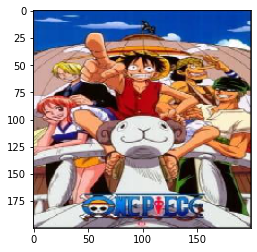

In [14]:
plt.imshow(df.loc[df['title']=='One Piece']['Posters'].values[0])

## Genre

Mengubah kolom genre yang hanya dipisahkan oleh <b>;</b> menjadi kolom-kolom terpisah

In [15]:
genre_col = df["misc"].str.split(";", n = 20, expand = True)

In [16]:
genre_list = []
for genre in genre_col.columns:
    genre_list=np.concatenate([genre_list,genre_col[genre].unique()])
    

In [17]:
genre_list = genre_list[genre_list!=None]
genre_list = np.unique(genre_list)

In [18]:
genre_list

array(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons',
       'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem', 'Historical',
       'Horror', 'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha',
       'Military', 'Music', 'Mystery', 'Parody', 'Police',
       'Psychological', 'Romance', 'Samurai', 'School', 'Sci-Fi',
       'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Vampire'], dtype=object)

In [19]:
genre_list.shape

(40,)

In [20]:
for genre in genre_list:
    df[genre] = df["misc"].apply(
        lambda values: int(genre in values.split(";"))
    )


In [21]:
new_df=df.sample(n=8000, random_state=3)

In [22]:
val_df = df[~df.index.isin(new_df.index)]

In [23]:
df.shape

(11558, 48)

In [24]:
new_df.shape

(8000, 48)

In [25]:
val_df.shape

(3558, 48)

# Data Preprocessing

Memisahkan kolom fitur dan target

In [26]:
X = new_df[['description','Posters']]
y = new_df[genre_list]

In [27]:
X

,description,Posters
1418,"The bustling metropolis of Kansai, where cyber...","[[[0.7058824, 0.32941177, 0.03137255], [0.8549..."
76,"Under the cover of darkness, a masked samurai ...","[[[0.11764706, 0.08235294, 0.0627451], [0.1098..."
5871,A mini movie released on the Fire Emblem Heroe...,"[[[0.023529412, 0.023529412, 0.05490196], [0.0..."
11640,Tokine Amino is the young and overburdened sec...,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,..."
6521,Azmaria Hendrick gives some background informa...,"[[[0.29411766, 0.25490198, 0.2509804], [0.9333..."
...,...,...
2202,"For many years, Ex-Marine Lieutenant Randolph ...","[[[0.6039216, 0.89411765, 1.0], [0.44313726, 0..."
4128,Genki is a boy who loves playing video games. ...,"[[[0.12941177, 0.3019608, 0.4392157], [0.12941..."
7192,"This is the story of Natsunosuke Honda, a pro ...","[[[0.047058824, 0.0627451, 0.10980392], [0.047..."
7689,"In this adaptation of a manga by Fumi Shibama,...","[[[0.99607843, 0.99607843, 0.99607843], [0.996..."


In [28]:
y

,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,...,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire
1418,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5871,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
11640,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6521,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0,1,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4128,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7192,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7689,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.3)

Data harus dibuat agar model bisa menerima jenis data nya
## Poster preprocessing

In [30]:
X_train_trf = np.array(X_train['Posters'].tolist())
X_test_trf = np.array(X_test['Posters'].tolist())

## Synopsis preprocessing

In [31]:
X_train_desc = X_train['description']
X_test_desc = X_test['description']

### Membersihkan data sinopsis dari punctuation dan stopwords

In [32]:
import string

def remove_punc(text):
    table = str.maketrans("","",string.punctuation)
    return text.translate(table)

X_train_desc = X_train_desc.map(lambda x: remove_punc(x))
X_test_desc = X_test_desc.map(lambda x: remove_punc(x))

In [33]:
# import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

X_train_desc = X_train_desc.map(remove_stopwords)
X_test_desc = X_test_desc.map(remove_stopwords)

In [34]:
from collections import Counter

def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] +=1
    return count

counter = counter_word(X_test_desc)
counter

Counter({'pekkle': 1,
         'recreates': 2,
         'story': 270,
         'aladdin': 3,
         'magic': 89,
         'lamp': 2,
         'unaired': 26,
         'ura': 1,
         'mirai': 15,
         'nikki': 2,
         'anime': 199,
         'short': 163,
         'episodes': 140,
         'mur': 2,
         'inserted': 2,
         'end': 113,
         'main': 56,
         'included': 103,
         'blurays': 5,
         'jack': 22,
         'moved': 16,
         'hokkaido': 8,
         'get': 122,
         'treatment': 7,
         'illness': 9,
         'hes': 45,
         'lonely': 17,
         'unhappy': 2,
         'one': 559,
         'night': 72,
         'man': 183,
         'horse': 17,
         'rides': 7,
         'window': 8,
         'help': 181,
         'reason': 19,
         'doesnt': 62,
         'understand': 17,
         'instantly': 10,
         'knows': 31,
         'mans': 11,
         'name': 77,
         'feels': 22,
         'theyve': 8,
         'met

In [35]:
X_test_desc

8946             pekkle recreates story aladdin magic lamp
6285     unaired ura mirai nikki anime short episodes m...
9894     jack moved hokkaido get treatment illness hes ...
4637     new year special episode recap first episodes ...
3774     tsubasa kazanari kanade amou—the idol duo know...
                               ...                        
11781    three specials came dvd release mostly depict ...
7747                     dvdbluray specials umi monogatari
2093     comical action adventure film set future world...
5184     based autobiography singer kawashima ai name b...
2320     music video created character brand video feat...
Name: description, Length: 2400, dtype: object

# Modeling

## Poster
Pertama-tama saya akan membuat model untuk poster saja. Untuk model ini saya menggunakan 3 layer convolutional neural network yang kemudian akan dilanjutkan dengan 2 layer dense

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
model = tf.keras.Sequential([

    keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(200,200,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),

#     keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(40, activation='sigmoid'),
])


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 196, 196, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 32)        1

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(X_train_trf, y_train, epochs=20, validation_data=(X_test_trf, y_test), batch_size=64)

Epoch 1/20
88/88 [==============================] - 18s 130ms/step - loss: 0.5828 - accuracy: 0.0505 - val_loss: 0.2868 - val_accuracy: 0.0587
Epoch 2/20
88/88 [==============================] - 10s 117ms/step - loss: 0.3508 - accuracy: 0.1155 - val_loss: 0.2749 - val_accuracy: 0.0733
Epoch 3/20
88/88 [==============================] - 10s 118ms/step - loss: 0.2981 - accuracy: 0.1714 - val_loss: 0.3890 - val_accuracy: 0.0621
Epoch 4/20
88/88 [==============================] - 10s 117ms/step - loss: 0.2752 - accuracy: 0.2450 - val_loss: 0.4147 - val_accuracy: 0.2958
Epoch 5/20
88/88 [==============================] - 10s 117ms/step - loss: 0.2607 - accuracy: 0.2807 - val_loss: 0.2952 - val_accuracy: 0.3413
Epoch 6/20
88/88 [==============================] - 10s 117ms/step - loss: 0.2509 - accuracy: 0.3154 - val_loss: 0.2505 - val_accuracy: 0.3754
Epoch 7/20
88/88 [==============================] - 10s 117ms/step - loss: 0.2428 - accuracy: 0.3254 - val_loss: 0.2689 - val_accuracy: 0.3333

### Evaluasi model poster

Disini kita bisa melihat kalau akurasi yang didapatkan tidak terlalu tinggi. Ini adalah hasil setelah mencoba berbagai jenis kombinasi activation, jumlah layer dan jumlah neuron

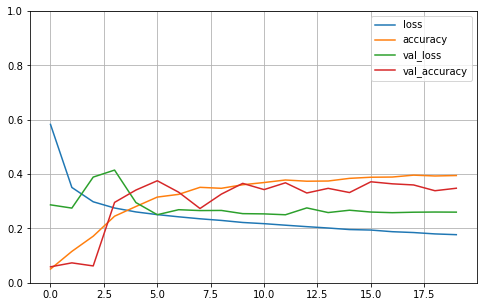

In [41]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

### Model Inference Poster

Disini saya mengambil 4 contoh title yang tidak termasuk dalam data training

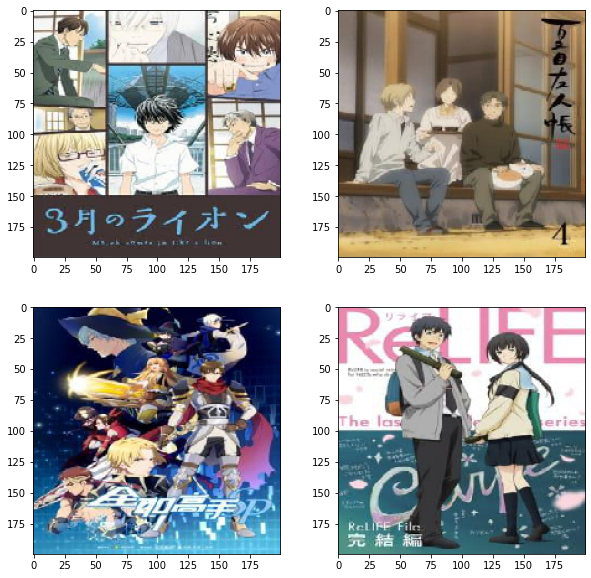

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))

ax1.imshow(val_df.iloc[0]['Posters'])
ax2.imshow(val_df.iloc[1]['Posters'])
ax3.imshow(val_df.iloc[2]['Posters'])
ax4.imshow(val_df.iloc[3]['Posters'])

Berikut adalah 10 genre teratas untuk ke 4 title ini. Bila dibandingkan dengan genre aslinya, hasil prediksi oleh model ini cukup banyak yang meleset. Ini kemungkinan disebabkan oleh trend dalam pembuatan poster dimana poster tidak selalu mencerminkan genre dari anime nya

In [43]:
val_df.iloc[[0,1,2,3],:][['title','misc']]

,title,misc
2,3-gatsu no Lion,Drama;Game;Seinen;Slice of Life
3,Natsume Yuujinchou Go Specials,Slice of Life;Demons;Supernatural;Drama;Shoujo
4,Quanzhi Gaoshou Specials,Action;Game
5,ReLIFE: Kanketsu-hen,Romance;School;Slice of Life


In [44]:
test_index = [0,1,2,3]
for idx in test_index:
    
    test = np.expand_dims(val_df.iloc[idx]['Posters'], axis=0)

    classes = np.array(y.columns) #Get array of all classes
    proba = model.predict(test)  #Get probabilities for each class
    sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories
    print(val_df.iloc[idx]['title'])
    for i in range(10):
        print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))
    print('')

3-gatsu no Lion
Music (0.281)
Comedy (0.271)
Romance (0.251)
Drama (0.241)
School (0.233)
Slice of Life (0.231)
Sci-Fi (0.0718)
Shoujo (0.0527)
Fantasy (0.0509)
Action (0.0341)

Natsume Yuujinchou Go Specials
Music (0.264)
Fantasy (0.221)
Adventure (0.203)
Drama (0.149)
Sci-Fi (0.103)
Comedy (0.058)
Romance (0.0571)
Action (0.0547)
Historical (0.0458)
Supernatural (0.0345)

Quanzhi Gaoshou Specials
Action (0.779)
Sci-Fi (0.529)
Adventure (0.339)
Fantasy (0.278)
Mecha (0.265)
Shounen (0.235)
Supernatural (0.125)
Comedy (0.104)
Drama (0.095)
Military (0.052)

ReLIFE: Kanketsu-hen
Comedy (0.598)
Seinen (0.218)
School (0.196)
Slice of Life (0.182)
Drama (0.16)
Romance (0.121)
Fantasy (0.0901)
Adventure (0.0764)
Action (0.0662)
Sci-Fi (0.0634)



Bila kita lihat secara keseluruhan, model ini tidak terlalu jauh tebakannya. Tabel ini menunjukan nilai rata-rata dan sum untuk prediksi dan data sebenarnya untuk setiap genre. Disini kita bisa lihat secara sekilas semakin umum genre itu muncul maka rata-rata dari prediksi itu semakin dekat dengan test

In [45]:
y_test_pred = model.predict(X_test_trf)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=classes)

pd.DataFrame([y_test_pred_df.mean(),y_test.mean(), y_test_pred_df.sum(), y_test.sum()], 
             index=['Mean - Predicted','Mean - test data', 'Sum - Predicted','Sum - test data']).T

,Mean - Predicted,Mean - test data,Sum - Predicted,Sum - test data
Action,0.307842,0.297500,738.821594,714.0
Adventure,0.193272,0.202083,463.853119,485.0
Cars,0.002662,0.007917,6.387836,19.0
Comedy,0.345867,0.400833,830.079956,962.0
Dementia,0.018973,0.031667,45.534763,76.0
Demons,0.026545,0.030833,63.707710,74.0
Drama,0.174969,0.188333,419.924805,452.0
Ecchi,0.058532,0.057083,140.477097,137.0
Fantasy,0.231749,0.217917,556.197510,523.0
Game,0.021885,0.026250,52.523945,63.0


In [46]:
print(classification_report(y_test.reset_index().drop(columns = 'index'),(y_test_pred_df<0.6).replace(False,0).replace(True,1), target_names=genre_list))

               precision    recall  f1-score   support

       Action       0.26      0.76      0.38       714
    Adventure       0.20      0.99      0.33       485
         Cars       0.01      1.00      0.02        19
       Comedy       0.38      0.85      0.53       962
     Dementia       0.03      1.00      0.06        76
       Demons       0.03      1.00      0.06        74
        Drama       0.19      1.00      0.32       452
        Ecchi       0.06      1.00      0.11       137
      Fantasy       0.22      0.99      0.36       523
         Game       0.03      1.00      0.05        63
        Harem       0.04      1.00      0.07        86
   Historical       0.07      1.00      0.13       162
       Horror       0.03      1.00      0.06        70
        Josei       0.01      1.00      0.02        21
         Kids       0.07      0.99      0.12       161
        Magic       0.08      0.99      0.15       195
 Martial Arts       0.03      1.00      0.06        71
        M

## Sinopsis

Sekarang saya akan mencoba membuat model dengan menerima sinopsis nya saja. Model ini mem-vectorize teks pada sinopsis dan memasukannya ke model sequential. Layer pertama adalah embedding, kemudian layer kedua adalah LSTM baru 2 layer dense terakhir sebagai output.

In [47]:
VOCAB_SIZE = 4000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train_desc.values)

In [48]:
encoder

In [49]:
# encoder(X_train_desc)[5:7]

In [50]:
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', 'source', ..., 'afterwards', 'abducted', '4th'],
      dtype='<U16')

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True,
        input_length=300),
    tf.keras.layers.LSTM(64),
    keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(40, activation ='sigmoid')
])

In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [54]:
history = model.fit(X_train_desc, y_train, epochs=20,
                    validation_data=(X_test_desc, y_test),
                    validation_steps=30)

Epoch 1/20


C:\Users\DEOWARDIMAN\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


174/175 [============================>.] - ETA: 0s - loss: 0.3303 - accuracy: 0.1584

C:\Users\DEOWARDIMAN\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


175/175 [==============================] - 10s 33ms/step - loss: 0.3299 - accuracy: 0.1587 - val_loss: 0.2454 - val_accuracy: 0.2683
Epoch 2/20
175/175 [==============================] - 4s 24ms/step - loss: 0.2527 - accuracy: 0.2343 - val_loss: 0.2413 - val_accuracy: 0.2688
Epoch 3/20
175/175 [==============================] - 4s 24ms/step - loss: 0.2442 - accuracy: 0.2839 - val_loss: 0.2352 - val_accuracy: 0.4338
Epoch 4/20
175/175 [==============================] - 4s 25ms/step - loss: 0.2354 - accuracy: 0.3646 - val_loss: 0.2319 - val_accuracy: 0.4504
Epoch 5/20
175/175 [==============================] - 4s 25ms/step - loss: 0.2284 - accuracy: 0.4430 - val_loss: 0.2293 - val_accuracy: 0.4487
Epoch 6/20
175/175 [==============================] - 4s 25ms/step - loss: 0.2225 - accuracy: 0.4577 - val_loss: 0.2283 - val_accuracy: 0.4521
Epoch 7/20
175/175 [==============================] - 4s 24ms/step - loss: 0.2182 - accuracy: 0.4762 - val_loss: 0.2255 - val_accuracy: 0.4442
Epoch 8/2

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2

### Evaluasi model sinopsis

Dari hasil evaluasi model ini, didapatkan nilai akurasi yang sedikit lebih baik dari model poster. Meskipun begitu model ini tidak bisa dibilang model yang baik

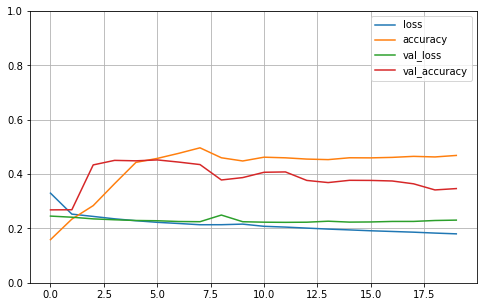

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

### Model Inference Sinopsis

Untuk contoh saya akan menggunakan 4 title yang tadi

In [57]:
test_index = [0,1,2,3]

for a in test_index:
    print(val_df.iloc[a]['title'])
    print(val_df.iloc[a]['description'])
    print('')

3-gatsu no Lion
Having reached professional status in middle school, Rei Kiriyama is one of the few elite in the world of shogi. Due to this, he faces an enormous amount of pressure, both from the shogi community and his adoptive family. Seeking independence from his tense home life, he moves into an apartment in Tokyo. As a 17-year-old living on his own, Rei tends to take poor care of himself, and his reclusive personality ostracizes him from his peers in school and at the shogi hall.,
,
However, not long after his arrival in Tokyo, Rei meets Akari, Hinata, and Momo Kawamoto, a trio of sisters living with their grandfather who owns a traditional wagashi shop. Akari, the oldest of the three girls, is determined to combat Rei's loneliness and poorly sustained lifestyle with motherly hospitality. The Kawamoto sisters, coping with past tragedies, also share with Rei a unique familial bond that he has lacked for most of his life. As he struggles to maintain himself physically and mentally 

Disini kita mendapatkan, walaupun nilai yang didapat banyak yang meleset dari sebenarnya, score nya sedikit lebih tinggi dari yang poster. Seakan modelnya lebih "yakin" akan tebakannya. Meskipun begitu tebakannya tidak tepat. Ini juga kemungkinan disebabkan oleh trend dalam penulisan sinopsis yang hanya menjelaskan premis dan setting ceritanya dan tidak mau ke intinya untuk menghindari spoiler

In [58]:
val_df.iloc[[0,1,2,3],:][['title','misc']]

,title,misc
2,3-gatsu no Lion,Drama;Game;Seinen;Slice of Life
3,Natsume Yuujinchou Go Specials,Slice of Life;Demons;Supernatural;Drama;Shoujo
4,Quanzhi Gaoshou Specials,Action;Game
5,ReLIFE: Kanketsu-hen,Romance;School;Slice of Life


In [59]:
test_desc = val_df.iloc[test_index]['description']
test_desc = test_desc.map(lambda x: remove_punc(x))
test_desc = test_desc.map(remove_stopwords)
for idx in test_index:
    classes = np.array(y.columns) #Get array of all classes
    proba = model.predict(test_desc.iloc[[idx]])  #Get probabilities for each class
    sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories
    print(val_df.iloc[idx]['title'])
    for i in range(10):
        print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))
    print('')

3-gatsu no Lion
Comedy (0.815)
School (0.716)
Romance (0.533)
Slice of Life (0.511)
Ecchi (0.267)
Drama (0.233)
Seinen (0.198)
Shounen (0.132)
Harem (0.125)
Shoujo (0.0956)

Natsume Yuujinchou Go Specials
Comedy (0.754)
Slice of Life (0.18)
School (0.0842)
Fantasy (0.0835)
Drama (0.0789)
Romance (0.0703)
Ecchi (0.0519)
Shounen (0.042)
Seinen (0.0411)
Parody (0.0361)

Quanzhi Gaoshou Specials
Action (0.704)
Supernatural (0.619)
Comedy (0.434)
Shounen (0.414)
Fantasy (0.41)
Mystery (0.327)
Drama (0.231)
Adventure (0.203)
Magic (0.203)
Romance (0.193)

ReLIFE: Kanketsu-hen
Comedy (0.43)
Slice of Life (0.338)
Drama (0.335)
Romance (0.303)
Shoujo (0.261)
School (0.259)
Fantasy (0.202)
Magic (0.172)
Historical (0.118)
Supernatural (0.102)



Untuk rata-rata dari setiap data test dan prediksi setiap genre, didapatkan kesimpulan yang serupa dengan model poster

In [60]:
y_test_pred = model.predict(X_test_desc)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=classes)

pd.DataFrame([y_test_pred_df.mean(),y_test.mean(), y_test_pred_df.sum(), y_test.sum()], 
             index=['Mean - Predicted','Mean - test data', 'Sum - Predicted','Sum - test data']).T

,Mean - Predicted,Mean - test data,Sum - Predicted,Sum - test data
Action,0.278464,0.297500,668.312744,714.0
Adventure,0.216930,0.202083,520.631836,485.0
Cars,0.005088,0.007917,12.210002,19.0
Comedy,0.389523,0.400833,934.854492,962.0
Dementia,0.026660,0.031667,63.983131,76.0
Demons,0.031374,0.030833,75.297989,74.0
Drama,0.174760,0.188333,419.424805,452.0
Ecchi,0.062177,0.057083,149.224197,137.0
Fantasy,0.249277,0.217917,598.263611,523.0
Game,0.032293,0.026250,77.503922,63.0


In [61]:
print(classification_report(y_test.reset_index().drop(columns = 'index'),(y_test_pred_df<0.6).replace(False,0).replace(True,1), target_names=genre_list))

               precision    recall  f1-score   support

       Action       0.22      0.57      0.31       714
    Adventure       0.17      0.78      0.28       485
         Cars       0.01      1.00      0.02        19
       Comedy       0.35      0.71      0.47       962
     Dementia       0.03      1.00      0.06        76
       Demons       0.03      1.00      0.06        74
        Drama       0.19      1.00      0.32       452
        Ecchi       0.06      1.00      0.11       137
      Fantasy       0.19      0.80      0.31       523
         Game       0.03      1.00      0.05        63
        Harem       0.04      1.00      0.07        86
   Historical       0.07      1.00      0.13       162
       Horror       0.03      1.00      0.06        70
        Josei       0.01      1.00      0.02        21
         Kids       0.07      0.99      0.12       161
        Magic       0.08      1.00      0.15       195
 Martial Arts       0.03      1.00      0.06        71
        M

## Model gabungan (Model Improvement)

Setelah melihat kedua model sebelumnya, saya akan menggabungkan kedua model tersebut menggunakan functional API. Harapannya adalah terjadinya penambahan dari akurasi

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
input_poster = keras.layers.Input(shape=(200,200,3), name='input_poster')
h = keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation="relu")(input_poster)
h = keras.layers.BatchNormalization()(h)
h = keras.layers.MaxPooling2D(pool_size=(2, 2))(h)
block_1_output = keras.layers.Dropout(0.2)(h)
h = keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu')(block_1_output)
h = keras.layers.MaxPooling2D(pool_size=(2, 2))(h)
h = keras.layers.BatchNormalization()(h)
block_2_output = keras.layers.Dropout(0.2)(h)
h = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu")(block_2_output)
h = keras.layers.MaxPooling2D(pool_size=(2, 2))(h)
h = keras.layers.BatchNormalization()(h)
block_3_output = keras.layers.Dropout(0.2)(h)
poster_output = keras.layers.Flatten()(block_3_output)

input_sinopsis = keras.layers.Input(shape=(1,),dtype='string')
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)(input_sinopsis)
embed = tf.keras.layers.Embedding(input_dim=4000,output_dim=64,mask_zero=True,input_length=300)(encoder)
h = tf.keras.layers.LSTM(64)(embed)
sinopsis_output = keras.layers.Dropout(0.3)(h)

concat = keras.layers.concatenate([poster_output, sinopsis_output])

h = tf.keras.layers.Dense(64, activation='relu')(concat)
h = keras.layers.Dropout(0.3)(h)
outputs = tf.keras.layers.Dense(40, activation ='sigmoid')(h)

model = tf.keras.Model(inputs=[input_poster, input_sinopsis], outputs=[outputs], name="model_gabungan")

In [64]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

In [65]:
history = model.fit((X_train_trf, X_train_desc), y_train, epochs=20,
                    validation_data=((X_test_trf, X_test_desc), y_test))

Epoch 1/20
175/175 [==============================] - 19s 92ms/step - loss: 0.4335 - accuracy: 0.1179 - val_loss: 0.2883 - val_accuracy: 0.1688
Epoch 2/20
175/175 [==============================] - 15s 87ms/step - loss: 0.2867 - accuracy: 0.2375 - val_loss: 0.3336 - val_accuracy: 0.1175
Epoch 3/20
175/175 [==============================] - 15s 87ms/step - loss: 0.2647 - accuracy: 0.3114 - val_loss: 0.2936 - val_accuracy: 0.3058
Epoch 4/20
175/175 [==============================] - 15s 88ms/step - loss: 0.2518 - accuracy: 0.3480 - val_loss: 0.3067 - val_accuracy: 0.1200
Epoch 5/20
175/175 [==============================] - 15s 86ms/step - loss: 0.2428 - accuracy: 0.3621 - val_loss: 0.2569 - val_accuracy: 0.3021
Epoch 6/20
175/175 [==============================] - 15s 88ms/step - loss: 0.2318 - accuracy: 0.3688 - val_loss: 0.2472 - val_accuracy: 0.3842
Epoch 7/20
175/175 [==============================] - 15s 85ms/step - loss: 0.2254 - accuracy: 0.3761 - val_loss: 0.2528 - val_accuracy:

### Model Evaluation

Seperti yang bisa dilihati disini tidak terjadi penambahan secara signifikan. Malahan model ini bisa dibilang lebih buruk dari model yang berisi sinopsis nya saja

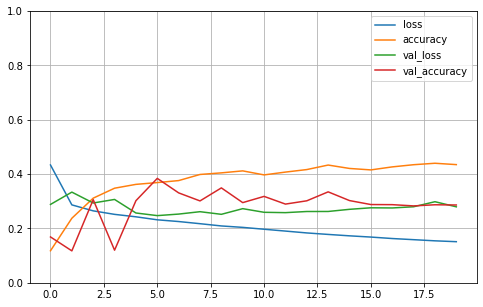

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [67]:
val_df.iloc[[0,1,2,3],:][['title','misc']]

,title,misc
2,3-gatsu no Lion,Drama;Game;Seinen;Slice of Life
3,Natsume Yuujinchou Go Specials,Slice of Life;Demons;Supernatural;Drama;Shoujo
4,Quanzhi Gaoshou Specials,Action;Game
5,ReLIFE: Kanketsu-hen,Romance;School;Slice of Life


In [75]:
test_index = [0,1,2,3]
for idx in test_index:
    
    test = np.expand_dims(val_df.iloc[idx]['Posters'], axis=0)

    classes = np.array(y.columns) #Get array of all classes
    proba = model.predict((test,test_desc.iloc[[idx]]))  #Get probabilities for each class
    sorted_categories = np.argsort(proba[0])[:-11:-1]  #Get class names for top 10 categories
    print(val_df.iloc[idx]['title'])
    for i in range(10):
        print("{}".format(classes[sorted_categories[i]])+" ({:.3})".format(proba[0][sorted_categories[i]]))
    print('')

3-gatsu no Lion
Comedy (0.39)
Slice of Life (0.127)
Sci-Fi (0.125)
Drama (0.12)
Adventure (0.111)
Parody (0.0773)
Historical (0.0699)
Action (0.0605)
Music (0.0523)
Fantasy (0.0322)

Natsume Yuujinchou Go Specials
Comedy (0.177)
Adventure (0.159)
Slice of Life (0.152)
Kids (0.114)
Drama (0.0872)
Sci-Fi (0.0657)
Dementia (0.045)
Supernatural (0.0449)
Fantasy (0.0299)
Seinen (0.0299)

Quanzhi Gaoshou Specials
Action (0.886)
Fantasy (0.838)
Adventure (0.835)
Shounen (0.489)
Comedy (0.28)
Sci-Fi (0.224)
Magic (0.161)
Supernatural (0.146)
Mecha (0.0406)
Super Power (0.0345)

ReLIFE: Kanketsu-hen
Comedy (0.464)
Sports (0.239)
Shounen (0.197)
Drama (0.127)
Action (0.0579)
Adventure (0.0523)
Slice of Life (0.0489)
School (0.0455)
Romance (0.0308)
Fantasy (0.0238)



In [76]:
y_test_pred = model.predict((X_test_trf,X_test_desc))
y_test_pred_df = pd.DataFrame(y_test_pred, columns=classes)

pd.DataFrame([y_test_pred_df.mean(),y_test.mean(), y_test_pred_df.sum(), y_test.sum()], 
             index=['Mean - Predicted','Mean - test data', 'Sum - Predicted','Sum - test data']).T

,Mean - Predicted,Mean - test data,Sum - Predicted,Sum - test data
Action,0.280180,0.297500,672.432190,714.0
Adventure,0.215718,0.202083,517.723206,485.0
Cars,0.004093,0.007917,9.823395,19.0
Comedy,0.371399,0.400833,891.356934,962.0
Dementia,0.023838,0.031667,57.211086,76.0
Demons,0.029440,0.030833,70.655067,74.0
Drama,0.178078,0.188333,427.387238,452.0
Ecchi,0.045111,0.057083,108.267494,137.0
Fantasy,0.224352,0.217917,538.444397,523.0
Game,0.024037,0.026250,57.688969,63.0


In [77]:
print(classification_report(y_test.reset_index().drop(columns = 'index'),(y_test_pred_df<0.6).replace(False,0).replace(True,1), target_names=genre_list))

               precision    recall  f1-score   support

       Action       0.26      0.74      0.38       714
    Adventure       0.19      0.91      0.32       485
         Cars       0.01      1.00      0.02        19
       Comedy       0.38      0.80      0.51       962
     Dementia       0.03      0.95      0.06        76
       Demons       0.03      1.00      0.06        74
        Drama       0.19      0.99      0.32       452
        Ecchi       0.06      1.00      0.11       137
      Fantasy       0.21      0.93      0.34       523
         Game       0.03      1.00      0.05        63
        Harem       0.04      1.00      0.07        86
   Historical       0.07      0.99      0.13       162
       Horror       0.03      1.00      0.06        70
        Josei       0.01      1.00      0.02        21
         Kids       0.07      0.99      0.12       161
        Magic       0.08      0.99      0.15       195
 Martial Arts       0.03      1.00      0.06        71
        M

# Kesimpulan

Dari ketiga model diatas dapat disimpulkan model yang berisi teks saja adalah model yang paling bagus. Model yang berisi gambar, dikarenakan jenis-jenis gambar yang bermacam-macam dan sulit ditebak, membuat model gabungan menjadi lebih buruk dari semestinya. Adapun model-model ini juga dapat ditingkatkan performanya mungkin dengan cara menggunakan dataset yang lebih seragam misalnya mempersempit cakupan anime yang diproduksi pada periode tertentu.